## Training

In this notebook, we will carry out hyperparameter tuning to find a good Latent Dirichlet Allocation (LDA) model.

In [1]:
# imports
import numpy as np
import sys
sys.path.insert(0, "../")
from dataset import ArXivDataset
from model import TopicModel
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
%config InlineBackend.figure_format="retina"

### Load dataset

While this notebook loads an already built and processed dataset or arXiv papers, a new dataset can be built and prepared using `ArXivDataset.from_metadata(...)`. See `dataset.py` for more details.

In [2]:
# load dataset
dataset_path = "../object/dataset.obj"
dataset = ArXivDataset.load(dataset_path)
print("# courses: {s}".format(s=len(dataset)))

# courses: 286


### Hyperparameter tuning

Now that we have loaded up the dataset, the next step is to train LDA models using a variety of hyperparameter combinations. For this particular dataset, I noticed that setting the number of topics to around 12-15 tends to yield the best results. The number of passes (epochs) will be fixed at a value of 5.

In [3]:
# set hyperparameters
number_of_topics = 150
num_topics_list = []
for i in range(1,number_of_topics):
    num_topics_list.append(i)
num_passes = 10
random_state = 929

Coherence Method c_npmi

segmentation -> probability calculation -> Confirmation measure -> aggregation

Segmentation: It uses the method S-one-set, that is, the confirmation measure will be computed over pairs of a word and the set W.

Probability Calculation: It uses the method Psw(110). The probabilities are calculated over a sliding window of size 110 that moves over the texts.

Confirmation Measure: It uses an indirect confirmation measure. The words of each pair’s elements are compared against all other words of W using the measure m_nlr. The final score is the cosine similarity between the two measures vectors.

Aggregation: The final coherence is the arithmetic mean of the confirmation measures.

In [4]:
# run grid search
model_list = []
score_list = []
for num_topics in num_topics_list:
    model = LdaModel(corpus=dataset.corpus, id2word=dataset.idx2word,
                     num_topics=num_topics, passes=num_passes,
                     random_state=random_state, per_word_topics=True)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=dataset.documents,
                                     dictionary=dataset.idx2word, coherence="c_v")
    score = coherence_model.get_coherence()
    score_list.append(score)
    print(" * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

 * num_topics: 01	score: 0.301
 * num_topics: 02	score: 0.315
 * num_topics: 03	score: 0.324
 * num_topics: 04	score: 0.337
 * num_topics: 05	score: 0.314
 * num_topics: 06	score: 0.334
 * num_topics: 07	score: 0.323
 * num_topics: 08	score: 0.332
 * num_topics: 09	score: 0.326
 * num_topics: 10	score: 0.329
 * num_topics: 11	score: 0.321
 * num_topics: 12	score: 0.318
 * num_topics: 13	score: 0.317
 * num_topics: 14	score: 0.318
 * num_topics: 15	score: 0.323
 * num_topics: 16	score: 0.331
 * num_topics: 17	score: 0.333
 * num_topics: 18	score: 0.311
 * num_topics: 19	score: 0.323
 * num_topics: 20	score: 0.344
 * num_topics: 21	score: 0.331
 * num_topics: 22	score: 0.329
 * num_topics: 23	score: 0.330
 * num_topics: 24	score: 0.331
 * num_topics: 25	score: 0.322
 * num_topics: 26	score: 0.323
 * num_topics: 27	score: 0.314
 * num_topics: 28	score: 0.326
 * num_topics: 29	score: 0.324
 * num_topics: 30	score: 0.333
 * num_topics: 31	score: 0.337
 * num_topics: 32	score: 0.339
 * num_t

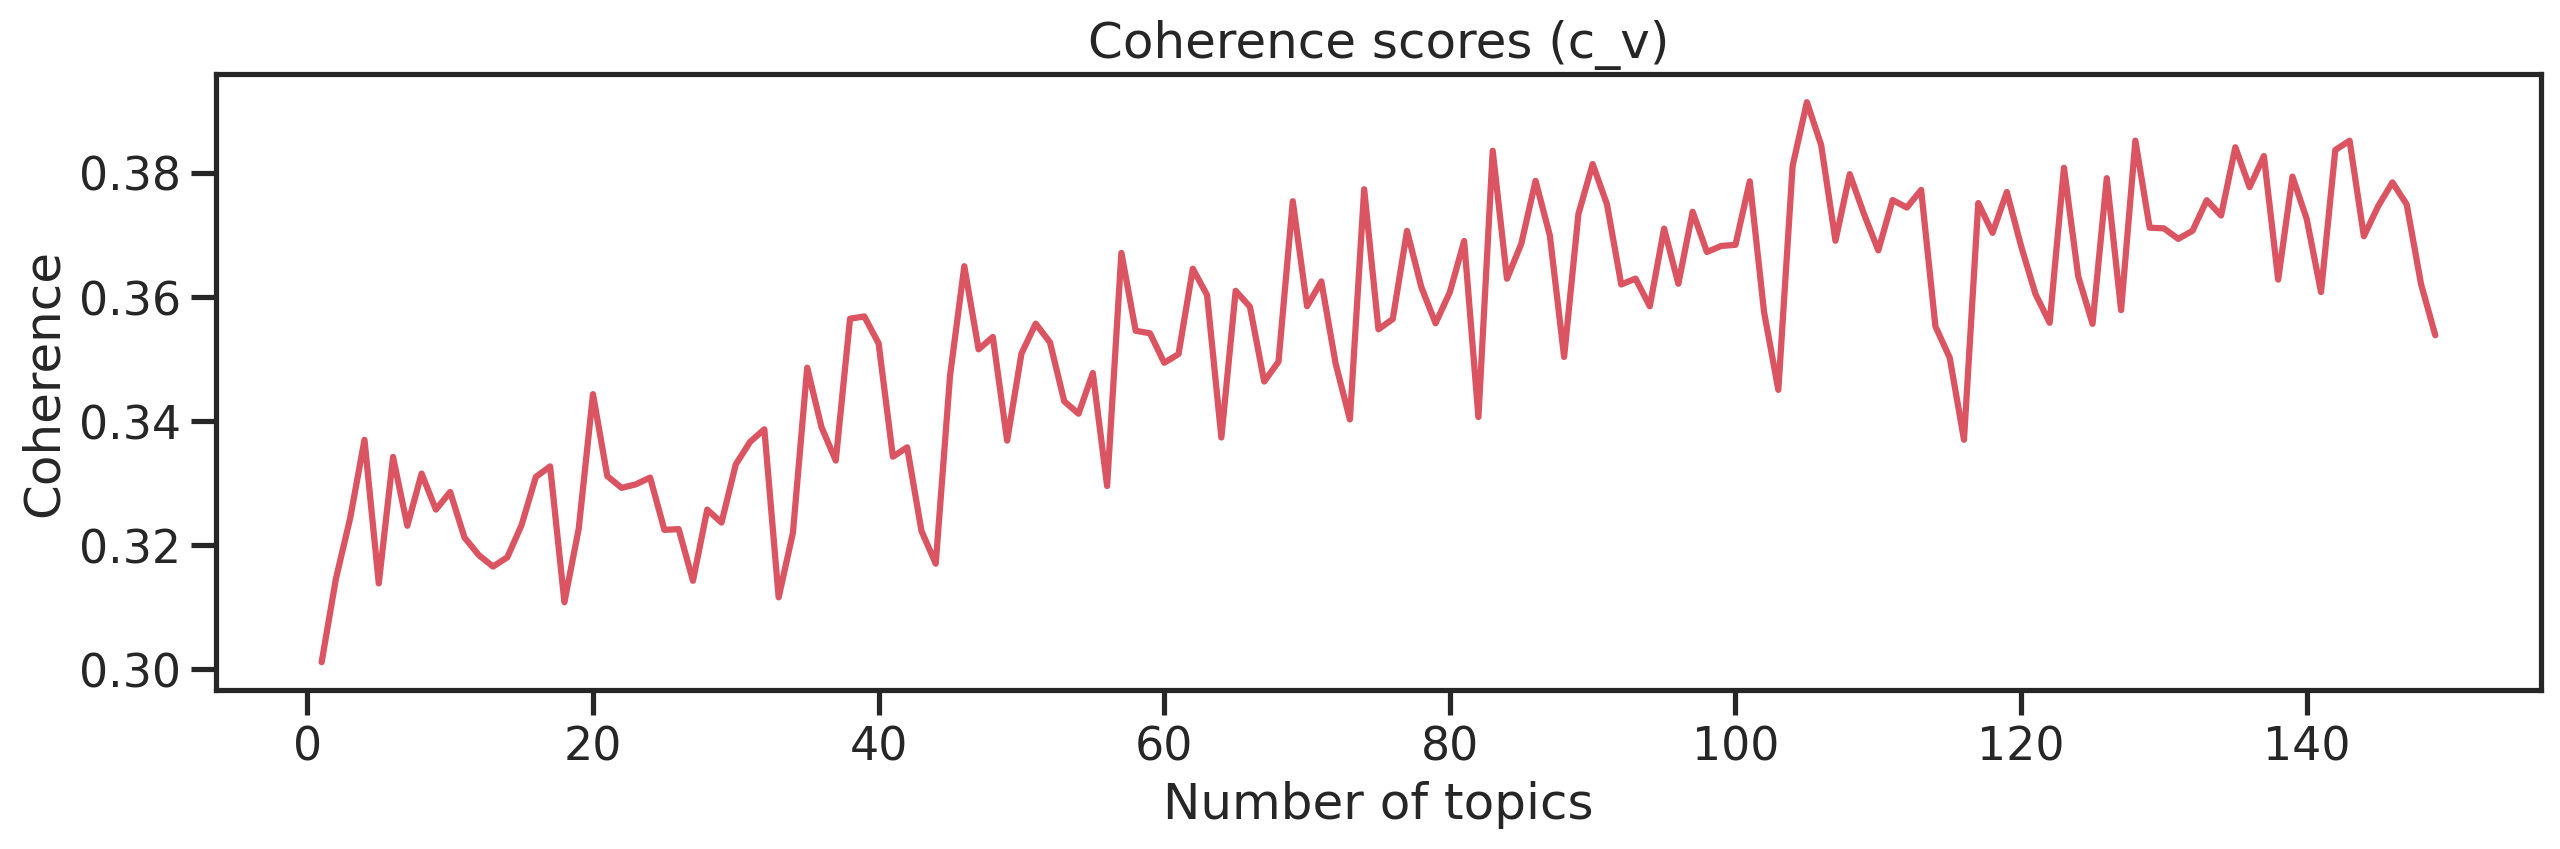

In [11]:
# plot coherence scores
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.set_title("Coherence scores (c_v)")
sns.lineplot(x=num_topics_list, y=score_list, color="#DB5461", 
             ax=ax, legend=False)
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.savefig("../data/plots/coherencescores.png",format="png", dpi=300)
plt.show()


From the above plot, it can be observed that setting the number of topics to be 12 would be optimal.

### Exporting the best model

Now that we have identified the best model, we can export it for inference in the future.

In [6]:
# export best model
best_idx = np.argmax(score_list)
best_model = model_list[best_idx]
best_score = score_list[best_idx]
num_topics = num_topics_list[best_idx]
best_model_path = "../models/lda_n{n}_p{p}_r{r}_c{c}".format(n=num_topics, p=num_passes,
                                                            r=random_state,
                                                            c=str(round(best_score * 100, 1)))
best_model.save(best_model_path)
print("Model saved to {path}".format(path=best_model_path))

Model saved to ../models/lda_n105_p10_r929_c39.1


In [7]:
# create topic model
model_path = best_model_path
dataset_path = "../object/dataset.obj"
model = TopicModel(model_path, dataset_path)

In [8]:
# print topics
pprint(model.topics)

[(0,
  [('system', 0.00064308546),
   ('control', 0.00046642686),
   ('problem', 0.0003609612),
   ('tool', 0.00031240965),
   ('model', 0.00027746803),
   ('description', 0.0002760079),
   ('complexity', 0.00027373905),
   ('logic', 0.00027366143),
   ('design', 0.0002652074),
   ('project', 0.00024900687)]),
 (1,
  [('system', 0.023838768),
   ('energy', 0.0150708025),
   ('design', 0.012751054),
   ('electronic', 0.012170386),
   ('problem', 0.009324392),
   ('tutorial', 0.008552619),
   ('model', 0.008287635),
   ('basic', 0.0075536296),
   ('lecture', 0.007428441),
   ('description', 0.007147056)]),
 (2,
  [('game', 0.052449316),
   ('strategy', 0.026261821),
   ('strategic', 0.021482978),
   ('games', 0.016608218),
   ('model', 0.0142783895),
   ('delivery', 0.013869685),
   ('player', 0.013686951),
   ('game_theory', 0.012409714),
   ('algorithm', 0.010465735),
   ('agent', 0.010398761)]),
 (3,
  [('system', 0.046363305),
   ('safety', 0.03733902),
   ('formal', 0.030734418),
  